# 0. Settings

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
print("PyTorch:", torch.__version__)
print("CUDA en PyTorch:", torch.version.cuda)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch: 2.5.1
CUDA en PyTorch: 12.1
CUDA disponible: True
GPU: NVIDIA GeForce RTX 3060


In [3]:
import torch
print(torch.version.cuda)  # Debe mostrar la versión de CUDA
print(torch.cuda.is_available())  # Debe ser True


12.1
True


In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [5]:
config = {
   "seed": 1974,
   "user": "Noelia"
}

torch.manual_seed(1974)

## Utils

### Reports

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_report(y_true, y_pred):
    # Reporte detallado
    report = classification_report(y_true, y_pred, digits=4)
    print(report)
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalizar por fila
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
                cbar_kws={'label': 'Prediccion'})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Porcentajes por clase)")
    plt.show()
    
    # Métricas globales
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy     : {acc:.4f}")
    print(f"Balanced Accuracy    : {bacc:.4f}")

    
# Now one that compares the reports for the training and validation sets
def compare_reports(y_train_true, y_train_pred, y_val_true, y_val_pred):
    print("Training Set Report:")
    create_report(y_train_true, y_train_pred)
    
    print("\nValidation Set Report:")
    create_report(y_val_true, y_val_pred)
    
    # Compare accuracies
    train_acc = accuracy_score(y_train_true, y_train_pred)
    val_acc = accuracy_score(y_val_true, y_val_pred)
    print(f"\nTraining Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
    
    # Provide a summary of the model's performance
    if train_acc > val_acc:
        print("The model performs better on the training set than on the validation set, indicating potential overfitting.")
    elif train_acc < val_acc:
        print("The model performs better on the validation set than on the training set, which is unusual but can happen with small datasets.")
    else:
        print("The model performs equally well on both sets, which is ideal.")
    
    # Visualize the performance
    plt.figure(figsize=(12, 6))
    sns.barplot(x=["Training Accuracy", "Validation Accuracy"], y=[train_acc, val_acc])
    plt.ylim(0, 1)
    plt.title("Training vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.show()


## 1. Imports


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 2. Load your Data (assuming a CSV file or similar)

In [8]:
# Replace this with your actual data loading
if (config["user"] == "Noelia"):
    df = pd.read_csv("C:/Users/Noelia/Documents/GitHub/RUROS/data/Ruros_Utheca_mediterranean.csv")  
elif (config["user"] == "Xopre"):
    df = pd.read_csv("C:/Users/rodga/OneDrive - UNIVERSIDAD DE SEVILLA/data/comfort/outdoor/Ruros_Utheca_mediterranean.csv")      


df = df.rename(columns={"heat": "y"})
df = df.dropna(subset=["y"])
df["y"] = df["y"] + 2




In [9]:
# Columns to select
columns_to_select = [#'Country', 
                     #'Site', 
                     'Season', 
                     #'Date', 
                     #'Time', 
                     #'Time_per', 
                     'age', 
                     'sex', 
                     #'sun_shade', 
                     'tair', 
                     #'tglobe', 
                     'wind_sp', 
                     'rh', 
                     'mrt', 
                     'clo', 
                     'met_rate', 
                     #'reas.there', 
                     #'loc_inha', 
                     #'nationality_group',
                     #"utci",
                     'y']  

df = df.astype({'Country': "category", 
                'Site': "category", 
                'Season': "category",
                'Time': "float64", 
                'Time_per': "category", 
                'age': "category", 
                'sex': "category", 
                'sun_shade': "category", 
                'tair': "float64", 
                'tglobe': "float64", 
                'wind_sp': "float64", 
                'rh': "float64", 
                'mrt': "float64", 
                'clo': "float64", 
                'met_rate': "float64", 
                'reas.there': "category", 
                'loc_inha': "category", 
                'nationality_group': "category",
                'y': "category"
})

df = df[columns_to_select]

# df

# 3. Preprocess

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE

# ==================================
# CONFIGURACIÓN
# ==================================
use_resampling = True   # ⬅️ Cambia entre True (con remuestreo) o False (sin remuestreo)
n_epochs = 10000
patience = 100
batch_size = 32
learning_rate = 1e-3
weight_decay = 1e-4
dropout = 0.5

# ==================================
# PREPROCESAMIENTO
# ==================================
X = df.drop(columns="y")
y = df["y"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

# Imputación
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

X[num_cols] = num_imputer.fit_transform(X[num_cols])
if len(cat_cols) > 0:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

# Preprocesador
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Preprocesamiento
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Pasar a numpy int
y_train = y_train.to_numpy().astype(int)
y_test  = y_test.to_numpy().astype(int)

# Balanceo con SMOTE SOLO sobre el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_proc, y_train)


## 4. Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)   # <<< CAMBIO A long
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CustomDataset(X_train_proc, y_train)
test_dataset = CustomDataset(X_test_proc, y_test)


if use_resampling:
    # Calcular pesos
    class_counts = np.bincount(y_train)     # cuenta cada clase
    class_weights = 1. / class_counts
    sample_weights = class_weights[y_train]  # asigna peso según la clase de cada muestra

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )


    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 5. Define Model

In [12]:
n_classes = len(np.unique(y_train))

class DeepBinaryMLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.6):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_rate),

            nn.Linear(32, n_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="leaky_relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

In [13]:
n = X_train_proc.shape[1]
print(n)

20


In [14]:
class SimpleBinaryMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleBinaryMLP, self).__init__()
        self.fc = nn.Linear(input_dim, n_classes)

    def forward(self, x):
        return self.fc(x) 


In [15]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepBinaryMLP(input_dim=X_train_proc.shape[1], dropout_rate=dropout).to(device)

# model = SimpleBinaryMLP(input_dim=179).to(device)
# Additional information
print("Device:", device)
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Reserved:  {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
model_size = sum(p.numel() * p.element_size() for p in model.parameters())

print(f"Model size: {model_size / 1024**2:.2f} MB")


Device: cuda
Allocated: 0.12 MB
Reserved:  2.00 MB
Model size: 0.12 MB


## 6. Loss and Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


## 7. Training Loop


## 7.1. Everything is loaded

In [17]:
print("Valores únicos en y_train:", np.unique(y_train))
print("dtype y_train:", y_train.dtype)


for X_batch, y_batch in train_loader:
    print("X contains NaN:", torch.isnan(X_batch).any().item())
    print("y contains NaN:", torch.isnan(y_batch).any().item())
    break


Valores únicos en y_train: [0 1 2 3 4]
dtype y_train: int64
X contains NaN: False
y contains NaN: False


In [18]:
best_loss = float("inf")
wait = 0
config = {}

print("⚙️ Entrenamiento iniciado")
print("📊 Train set:", len(train_dataset), "muestras")
print("📊 Test set:", len(test_dataset), "muestras")
print("🔄 Remuestreo activado:", use_resampling)

train_accuracies = []
val_accuracies = []

for epoch in range(1, n_epochs + 1):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)              # [batch, n_classes]
        loss = criterion(outputs, y_batch)    # CrossEntropy espera y_batch long

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

        preds = torch.argmax(outputs, dim=1)  # clase predicha
        correct_train += preds.eq(y_batch).sum().item()
        total_train += y_batch.size(0)

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # --- VALIDATION ---
    model.eval()
    val_loss_total = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            val_outputs = model(X_batch)             # [batch, n_classes]
            val_loss = criterion(val_outputs, y_batch)
            val_loss_total += val_loss.item() * X_batch.size(0)

            preds_val = torch.argmax(val_outputs, dim=1)  # multiclase
            y_pred.extend(preds_val.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())

    avg_val_loss = val_loss_total / len(test_loader.dataset)
    val_acc = accuracy_score(y_true, y_pred)
    val_bal_acc = balanced_accuracy_score(y_true, y_pred)
    val_accuracies.append(val_acc)

    # --- EARLY STOPPING ---
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        wait = 0
        torch.save(model, "MLP_multiclass.pt")

    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping en epoch {epoch} después de {patience} sin mejora.")
            config["real_epochs"] = epoch
            break

    # --- LOGGING ---
    if epoch % 10 == 0 or epoch == 1:
        avg_train_loss = running_loss / total_train
        print(
            f"Epoch {epoch}: "
            f"Train Acc ({'con' if use_resampling else 'sin'} remuestreo) = {train_acc:.4f}, "
            f"Val Acc = {val_acc:.4f}, "
            f"Val BalAcc = {val_bal_acc:.4f}, "
            f"Val Loss = {avg_val_loss:.4f}"
        )

print("✅ Entrenamiento finalizado")


⚙️ Entrenamiento iniciado
📊 Train set: 3835 muestras
📊 Test set: 1644 muestras
🔄 Remuestreo activado: True
Epoch 1: Train Acc (con remuestreo) = 0.2342, Val Acc = 0.3698, Val BalAcc = 0.3868, Val Loss = 1.5006
Epoch 10: Train Acc (con remuestreo) = 0.4203, Val Acc = 0.3400, Val BalAcc = 0.4608, Val Loss = 1.3548
Epoch 20: Train Acc (con remuestreo) = 0.4563, Val Acc = 0.3771, Val BalAcc = 0.4703, Val Loss = 1.2866
Epoch 30: Train Acc (con remuestreo) = 0.4704, Val Acc = 0.3729, Val BalAcc = 0.5058, Val Loss = 1.2719
Epoch 40: Train Acc (con remuestreo) = 0.4923, Val Acc = 0.3224, Val BalAcc = 0.5086, Val Loss = 1.3067
Epoch 50: Train Acc (con remuestreo) = 0.4860, Val Acc = 0.3698, Val BalAcc = 0.5111, Val Loss = 1.2365
Epoch 60: Train Acc (con remuestreo) = 0.4949, Val Acc = 0.3802, Val BalAcc = 0.5237, Val Loss = 1.2369
Epoch 70: Train Acc (con remuestreo) = 0.5179, Val Acc = 0.3899, Val BalAcc = 0.5219, Val Loss = 1.2324
Epoch 80: Train Acc (con remuestreo) = 0.4996, Val Acc = 0.334

## 7.2. Dataloader required

In [19]:
# for epoch in range(1, config["n_epochs"] + 1):
#     model.train()
#     epoch_loss = 0.0
#     for xb, yb in loader:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         output = model(xb)
#         loss = criterion(output, yb)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")

# Step 3: Evaluate and Show Metrics

## Fast visualization

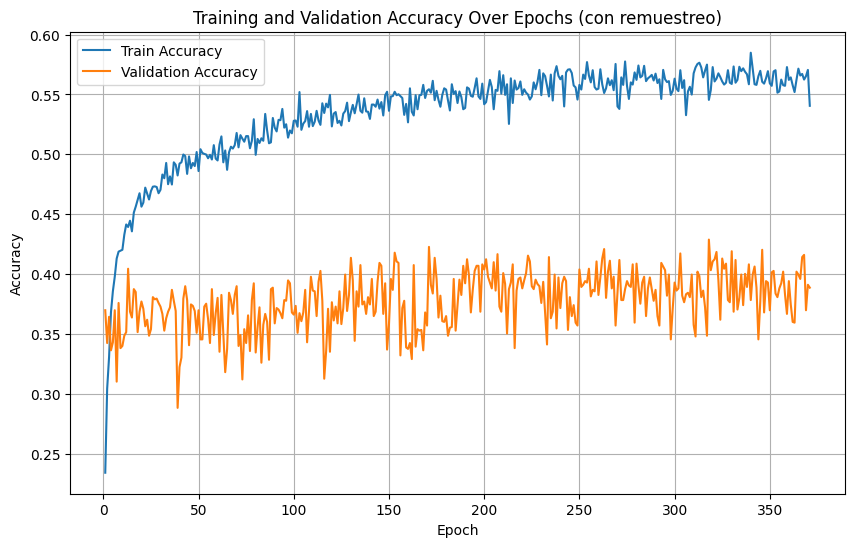

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
if "real_epochs" in config:  # early stopping activado
    plt.plot(range(1, config["real_epochs"] + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, config["real_epochs"] + 1), val_accuracies, label='Validation Accuracy')
else:  # sin early stopping
    plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy Over Epochs ({ "con" if use_resampling else "sin"} remuestreo)')
plt.legend()
plt.grid(True)
plt.show()


## 8. Evaluation - train

              precision    recall  f1-score   support

           0     0.4176    1.0000    0.5891       152
           1     0.4654    0.5263    0.4940       933
           2     0.6337    0.3454    0.4471      1708
           3     0.4145    0.3421    0.3748       871
           4     0.2219    0.9942    0.3629       171

    accuracy                         0.4435      3835
   macro avg     0.4306    0.6416    0.4536      3835
weighted avg     0.5160    0.4435    0.4440      3835



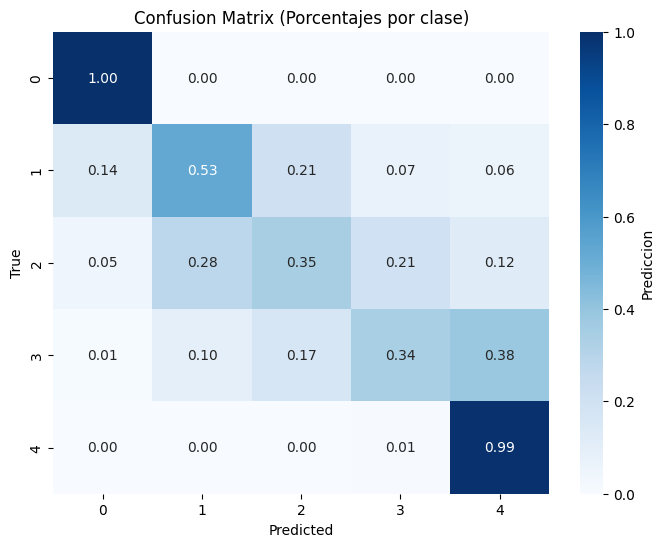

Overall Accuracy     : 0.4435
Balanced Accuracy    : 0.6416


In [22]:
# Cargar mejor modelo
#model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# ---- Train report ----
with torch.no_grad():
    X_tensor = torch.tensor(X_train_proc, dtype=torch.float32).to(device)
    outputs = model(X_tensor)  # [N, n_classes]
    preds = torch.argmax(outputs, dim=1).cpu().numpy()  # clase predicha

create_report(y_train, preds)

In [23]:
y_test.shape
X_test_proc.shape

(1644, 20)

## 9. Evaluation - test

              precision    recall  f1-score   support

           0     0.3503    0.8462    0.4955        65
           1     0.4257    0.4800    0.4512       400
           2     0.5948    0.3128    0.4100       732
           3     0.3494    0.2914    0.3178       374
           4     0.1593    0.7397    0.2621        73

    accuracy                         0.3887      1644
   macro avg     0.3759    0.5340    0.3873      1644
weighted avg     0.4688    0.3887    0.3959      1644



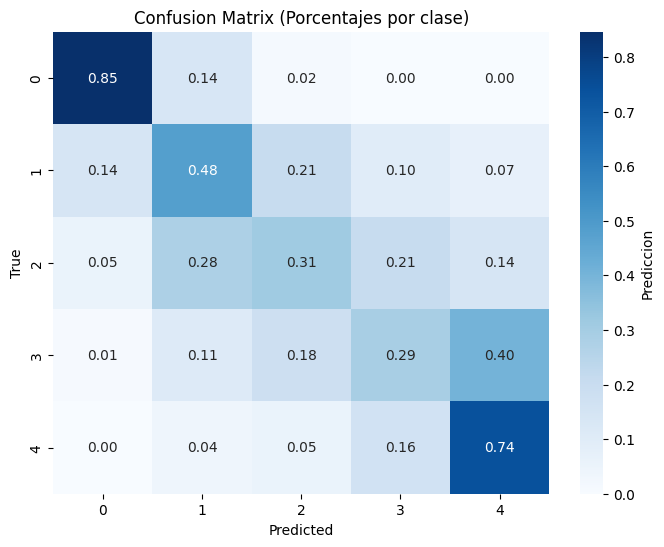

Overall Accuracy     : 0.3887
Balanced Accuracy    : 0.5340


In [24]:


# ---- Test report ----
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    outputs = model(X_test_tensor)  # [N, n_classes]
    preds = torch.argmax(outputs, dim=1).cpu().numpy()  # clase predicha

create_report(y_test, preds)
